<a href="https://colab.research.google.com/github/AliMekky/Grad_proj_FL/blob/main/FLWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib
from collections import OrderedDict
from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

from google.colab import drive
drive.mount('/content/drive')

Training on cpu using PyTorch 2.1.0+cu118 and Flower 1.5.0
Mounted at /content/drive


In [ ]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [ ]:
NUM_CLIENTS = 10

In [ ]:
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    print(type(trainset))
    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))
    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        print(lengths)
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified
<class 'torchvision.datasets.cifar.CIFAR10'>
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]
[4500, 500]


each trainloader/ valloader pair contains 4500 training examples and 500 validation examples and there is a single test loader

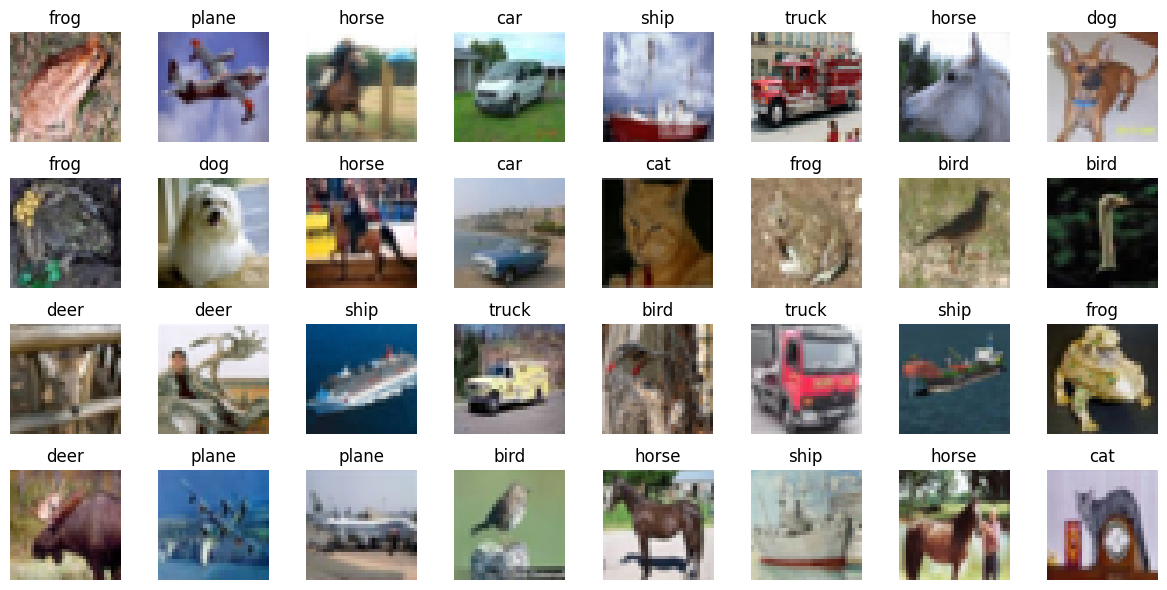

In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

# centralized training with pytorch

In [69]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StrokeNN(nn.Module):
    def __init__(self):
        super(StrokeNN, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 1)
        self.act = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = x.to(torch.float)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        return self.sigmoid(self.fc4(x))

In [72]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            # _, preds_y = torch.max(outputs, 1)
            threshold = 0.5
            predicted = (outputs >= threshold).float()

            # Convert to integers (0 or 1)
            predicted = predicted.int()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            loss += criterion(outputs, labels).item()
            # _, predicted = torch.max(outputs.data, 1)
            threshold = 0.5
            predicted = (outputs >= threshold).float()

            # Convert to integers (0 or 1)
            predicted = predicted.int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

basic building blocks:

1.   a dataset
2.   a model
3.   a training function
4.   a test function



### training the first organization with centralized approach

In [73]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = StrokeNN().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.02656209557803709, accuracy 0.7761194029850746
Epoch 2: validation loss 0.024529139052576095, accuracy 0.7910447761194029
Epoch 3: validation loss 0.023721338652852756, accuracy 0.8059701492537313
Epoch 4: validation loss 0.02346454449553988, accuracy 0.7761194029850746
Epoch 5: validation loss 0.023755686496620746, accuracy 0.7910447761194029
Final test set performance:
	loss 0.015145297599049796
	accuracy 0.768141592920354


# Federated Learning with Flower

## needed functions:


*   set_parameters: set the parameters of clients
*   get_parameters: get the parameters from the cient to update the global model.<br>
This function extracts the parameters from a PyTorch model (net) and returns them as a list of NumPy arrays. The purpose of this function is to convert the model parameters into a format that can be easily transmitted over the network to the server during a federated learning round. where each array represents the parameters of a layer in the model.



note: state_dict is used to access pytorch model parameters tensors that are then converted to/from a list of Numpy ndarrays (which flower knows how to serialize/deserialize)

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## implementing a Flower Client

To implement a flower client, we create a subclass of flwr.client.Client or flwr.client.NumPyClient (NumPyClient is simpler, it is required to know the difference and which one is uitable to use)

then we implement get_paramaters, fit and evaluate methods


*   get_parameters: Return the current local params
*   fit: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
*   evaluate: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

## Virtual Client Engine

To enable the Flower framework to create clients when necessary, we need to implement a function called client_fn that creates a FlowerClient instance on demand. Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short cid. The cid can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

## Starting the training:

The function start_simulation accepts a number of arguments, amongst them the client_fn used to create FlowerClient instances, the number of clients to simulate (num_clients), the number of federated learning rounds (num_rounds), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, Federated Averaging (FedAvg).

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flwr 2023-10-19 17:56:29,953 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-10-19 17:56:34,553	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-19 17:56:37,815 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3930513408.0, 'memory': 7861026816.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3930513408.0, 'memory': 7861026816.0}
INFO flwr 2023-10-19 17:56:37,824 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-19 17:56:37,831 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.06415844326019288
	round 2: 0.05549075422286988
	round 3: 0.05261460499763489
	round 4: 0.05012789092063904
	round 5: 0.04862811632156371

## behind the scenes

When we call start_simulation, we tell Flower that there are 10 clients (num_clients=10). Flower then goes ahead an asks the FedAvg strategy to select clients. FedAvg knows that it should select 100% of the available clients (fraction_fit=1.0), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (FedAvg) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

Accuracy:

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-10-19 18:01:16,153 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-10-19 18:01:21,689	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-19 18:01:24,282 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3926066380.0, 'memory': 7852132763.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3926066380.0, 'memory': 7852132763.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-10-19 18:01:24,287 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-19 18:01:24,297 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.06187276978492736
	round 2: 0.05452750935554505
	round 3: 0.05144535641670227
	round 4: 0.050792041730880734
	round 5: 0.04891911482810974
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.2876), (2, 0.37039999999999995), (3, 0.40040000000000003), (4, 0.4104), (5, 0.4404)]}

# Strategy Customization

## Server-side parameter initialization

Flower, by default, initializes the global model by asking one random client for the initial parameters. In many cases, we want more control over parameter initialization though. Flower therefore allows you to directly pass the initial parameters to the Strategy

In [ ]:
# # Create an instance of the model and get the parameters
# params = get_parameters(Net())

# # Pass parameters to the Strategy for server-side parameter initialization
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.3,
#     fraction_evaluate=0.3,
#     min_fit_clients=3,
#     min_evaluate_clients=3,
#     min_available_clients=NUM_CLIENTS,
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
# )

# # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
# client_resources = None
# if DEVICE.type == "cuda":
#     client_resources = {"num_gpus": 1}

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
#     strategy=strategy,
#     client_resources=client_resources,
# )

Passing initial_parameters to the FedAvg strategy prevents Flower from asking one of the clients for the initial parameters. If we look closely, we can see that the logs do not show any calls to the FlowerClient.get_parameters method.

## Customized strategy

### Server-side parameter evaluation

Flower can evaluate the aggregated model on the server-side or on the client-side. Client-side and server-side evaluation are similar in some ways, but different in others.

Centralized Evaluation (or server-side evaluation) is conceptually simple: it works the same way that evaluation in centralized machine learning does. If there is a server-side dataset that can be used for evaluation purposes, then that’s great. We can evaluate the newly aggregated model after each round of training without having to send the model to clients. We’re also fortunate in the sense that our entire evaluation dataset is available at all times.

Federated Evaluation (or client-side evaluation) is more complex, but also more powerful: it doesn’t require a centralized dataset and allows us to evaluate models over a larger set of data, which often yields more realistic evaluation results. In fact, many scenarios require us to use Federated Evaluation if we want to get representative evaluation results at all. But this power comes at a cost: once we start to evaluate on the client side, we should be aware that our evaluation dataset can change over consecutive rounds of learning if those clients are not always available. Moreover, the dataset held by each client can also change over consecutive rounds. This can lead to evaluation results that are not stable, so even if we would not change the model, we’d see our evaluation results fluctuate over consecutive rounds.

In [ ]:
# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [ ]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    evaluate_fn=evaluate,  # Pass the evaluation function
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-10-19 18:06:12,925 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-10-19 18:06:17,411	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-19 18:06:19,949 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3928750080.0, 'memory': 7857500160.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3928750080.0, 'memory': 7857500160.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-10-19 18:06:19,961 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-19 18:06:19,971 | app.py:224 | Flower VCE: Resources for each Virtual Clie

Server-side evaluation loss 0.07389125299453736 / accuracy 0.1


(pid=3781) 2023-10-19 18:06:30.757024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-10-19 18:06:50,441 | server.py:236 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-10-19 18:06:50,460 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-10-19 18:06:50,685 | server.py:125 | fit progress: (1, 0.06260328769683837, {'accuracy': 0.29}, 29.714180085000066)
INFO:flwr:fit progress: (1, 0.06260328769683837, {'accuracy': 0.29}, 29.714180085000066)
DEBUG flwr 2023-10-19 18:06:50,693 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.06260328769683837 / accuracy 0.29


DEBUG flwr 2023-10-19 18:06:55,558 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-10-19 18:06:55,566 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-10-19 18:06:55,569 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG flwr 2023-10-19 18:07:10,104 | server.py:236 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-10-19 18:07:10,339 | server.py:125 | fit progress: (2, 0.05546332883834839, {'accuracy': 0.352}, 49.36854470800006)
INFO:flwr:fit progress: (2, 0.05546332883834839, {'accuracy': 0.352}, 49.36854470800006)
DEBUG flwr 2023-10-19 18:07:10,346 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05546332883834839 / accuracy 0.352


DEBUG flwr 2023-10-19 18:07:15,697 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-10-19 18:07:15,705 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG flwr 2023-10-19 18:07:28,889 | server.py:236 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-10-19 18:07:29,154 | server.py:125 | fit progress: (3, 0.053238537073135375, {'accuracy': 0.366}, 68.184146597)
INFO:flwr:fit progress: (3, 0.053238537073135375, {'accuracy': 0.366}, 68.184146597)
DEBUG flwr 2023-10-19 18:07:29,159 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.053238537073135375 / accuracy 0.366


DEBUG flwr 2023-10-19 18:07:37,827 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
INFO flwr 2023-10-19 18:07:37,834 | server.py:153 | FL finished in 76.86338894000005
INFO:flwr:FL finished in 76.86338894000005
INFO flwr 2023-10-19 18:07:37,840 | app.py:225 | app_fit: losses_distributed [(1, 0.06248187549908955), (2, 0.055707002162933346), (3, 0.05212635978062948)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06248187549908955), (2, 0.055707002162933346), (3, 0.05212635978062948)]
INFO flwr 2023-10-19 18:07:37,845 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-10-19 18:07:37,848 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-10-19 18:07:37,851 | app.py:228 | app_fit: losses_centralized [(0, 0.07389125299453736), (1, 0.06260328769683837), (2, 0.05546332883834839), (3, 0.053238537073135

History (loss, distributed):
	round 1: 0.06248187549908955
	round 2: 0.055707002162933346
	round 3: 0.05212635978062948
History (loss, centralized):
	round 0: 0.07389125299453736
	round 1: 0.06260328769683837
	round 2: 0.05546332883834839
	round 3: 0.053238537073135375
History (metrics, centralized):
{'accuracy': [(0, 0.1), (1, 0.29), (2, 0.352), (3, 0.366)]}

# Sending/receiving arbitrary values to/from clients


In some situations, we want to configure client-side execution (training, evaluation) from the server-side. One example for that is the server asking the clients to train for a certain number of local epochs. Flower provides a way to send configuration values from the server to the clients using a dictionary. Let’s look at an example where the clients receive values from the server through the config parameter in fit (config is also available in evaluate). The fit method receives the configuration dictionary through the config parameter and can then read values from this dictionary. In this example, it reads server_round and local_epochs and uses those values to improve the logging and configure the number of local training epochs

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

So how can we send this config dictionary from server to clients? The built-in Flower Strategies provide way to do this, and it works similarly to the way server-side evaluation works. We provide a function to the strategy, and the strategy calls this function for every round of federated learning:

In [ ]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config

In [ ]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

Clients can also return arbitrary values to the server. To do so, they return a dictionary from fit and/or evaluate. We have seen and used this concept throughout this notebook without mentioning it explicitly: our FlowerClient returns a dictionary containing a custom key/value pair as the third return value in evaluate.

# Scaling Federated Learning Strategy

using federated learning with large number of clients

with large number of clients, each client has small number of examples.
so we train each client with more number of local epochs, and select only small number of clients at each round

Due to limited communication bandwidth and unstable availability of such devices in a mobile network, only a fraction of end devices (also referred to as the participants or clients in a FL process) can be selected in each round.

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": 3,
        # increase number of local epochs at each client
    }
    return config


strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.025,  # Train on 25 clients (each round)
    fraction_evaluate=0.05,  # Evaluate on 50 clients (each round)
    min_fit_clients=20,
    min_evaluate_clients=40,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    on_fit_config_fn=fit_config,
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

# Build a strategy from a scratch

to implement a strategy from a scratch


1.   extends fl.server.startegy.Strategy
2.   override the following function:
 initialize_parameters, configure_fit, aggregate_fit, configure_evaluate,
aggregate_evaluate, evaluate, num_fit_clients and num_evaluate_clients.




In [ ]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

**EvaluateIns, EvaluateRes, FitIns, FitRes:** These classes are used to define the data structures for exchanging information between the server and clients during the evaluation and training phases of federated learning. EvaluateIns represents the input data for evaluation, EvaluateRes represents the evaluation results, FitIns represents the input data for training, and FitRes represents the training results.<br>
Ins --> instructions, that are get before each training. <br>
Res --> response, that are returned after each training.<br>
each client has its Ins and Res.

**MetricsAggregationFn:** This is a function type used for defining how metrics should be aggregated. It specifies how metrics collected from multiple clients should be combined into a single aggregated metric.

**NDArrays**: This is a type hint for NumPy arrays. It's used to specify that certain data should be represented as NumPy arrays.

**Parameters**: This class is used to represent model parameters, typically in a format that can be transmitted between the server and clients.

**Scalar**: This is a type hint for a single numeric value, typically representing scalar metrics or values.

**ndarrays_to_parameters, parameters_to_ndarrays:** These functions are used for converting between the Parameters class and NumPy arrays. ndarrays_to_parameters converts NumPy arrays to the Parameters format, and parameters_to_ndarrays does the reverse, converting Parameters to NumPy arrays.

**Client Manager**: holds all currently connected clients --> used to acccess available clients and return a list of them.

**Client Proxy**: deals with a specific client, where each connected client has a proxy (server communicates with the proxy and the proxy communicates with the client, as no direct communication between the server and the client) based on the architecture of Flwr --> data type of the clients returned by the client manager.

### Edge Client engine

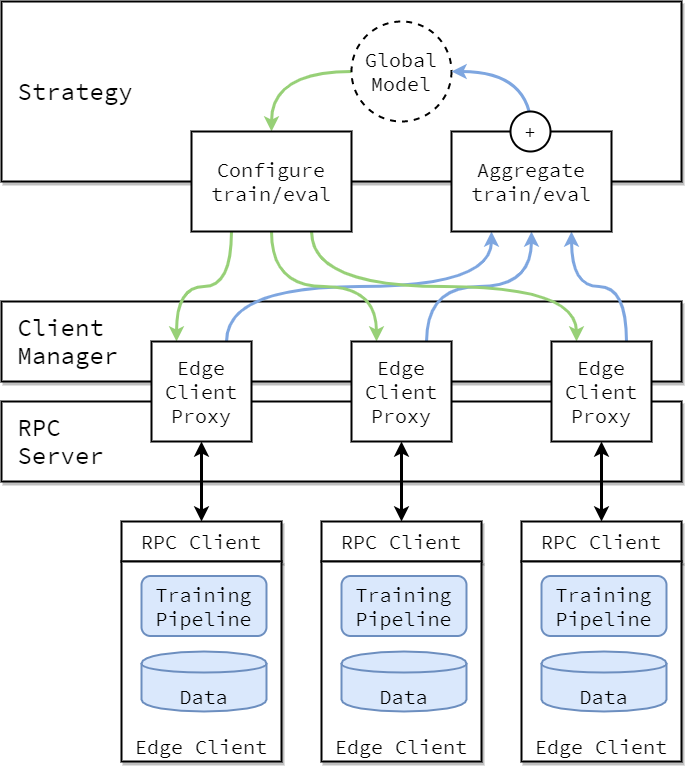

### Virtual Client engine

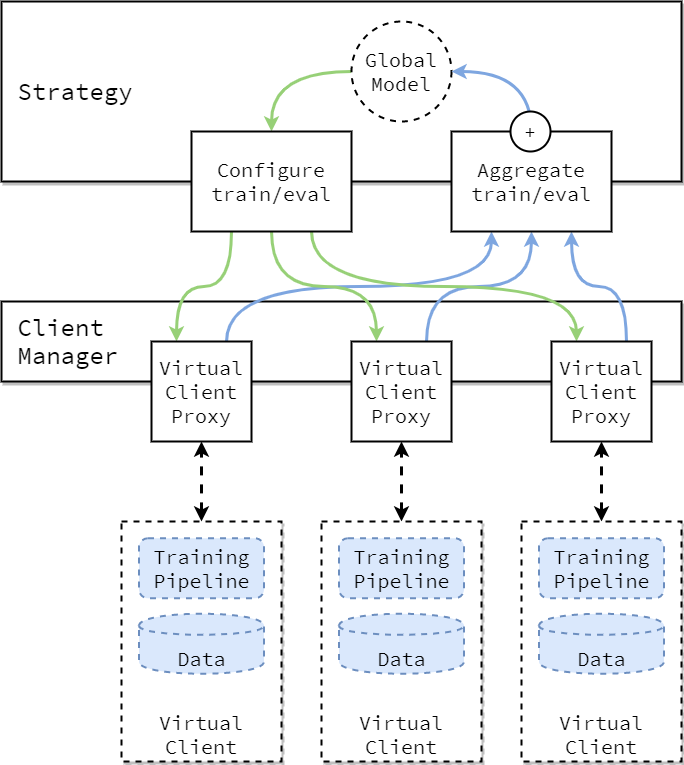

### Virtual client engine and edge client engine

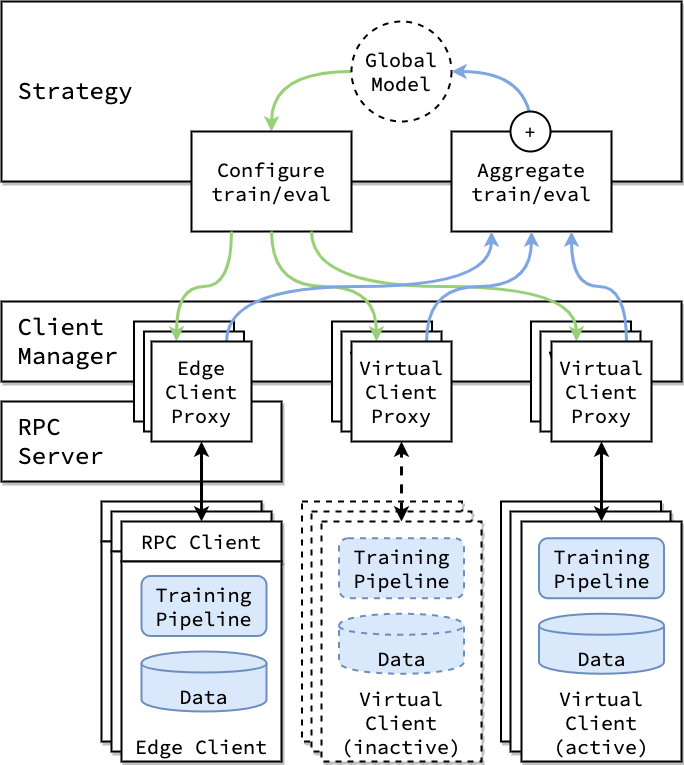

### Custom Strategy

In [ ]:
class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [ ]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=FedCustom(),  # <-- pass the new strategy here
    client_resources=client_resources,
)

INFO flwr 2023-10-19 18:55:35,560 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-10-19 18:55:40,104	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-19 18:55:44,349 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3926631628.0, 'memory': 7853263259.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3926631628.0, 'memory': 7853263259.0, 'CPU': 2.0}
INFO flwr 2023-10-19 18:55:44,355 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-19 18:55:44,361 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.06317011106014252
	round 2: 0.05701576101779938
	round 3: 0.053581655144691466

# Pipeline Class

Pipeline:
1. config file.
2. prepare the dataset.
3. define the clients.
4. define the strategy.
5. start simulation.
6. save the results.


## Imports

In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib torchmetrics ray
from collections import OrderedDict
from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import torchmetrics
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
torch.manual_seed(42)

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4

## Dataset Class

In [2]:
from torch.utils.data import Dataset
import pandas as pd

class StrokeData(Dataset):
    def __init__(self, csv_path):
        input_df = pd.read_csv(csv_path)
        input_df = input_df[:6770]
        self.df = input_df.copy()
        self.y = input_df.pop('stroke').to_frame()
        self.X = input_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.X.iloc[idx]), torch.tensor(self.y.iloc[idx])

In [3]:
BATCH_SIZE = 32
NUM_CLIENTS = 10

def load_datasets():

    trainset = StrokeData("/content/drive/MyDrive/Stroke/processed_stroke_train_new.csv")
    testset = StrokeData("/content/drive/MyDrive/Stroke/processed_stroke_test_new.csv")
    print(len(trainset))
    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    print(lengths)
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))
    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        print(lengths)
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

6770
[677, 677, 677, 677, 677, 677, 677, 677, 677, 677]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]
[610, 67]


## Flower Client



In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


## duplicate code, already written as a method in the pipeline class.
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)



## Model

In [74]:
class StrokeNN(nn.Module):
    def __init__(self):
        super(StrokeNN, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 1)
        self.act = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = x.to(torch.float)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        return self.sigmoid(self.fc4(x))

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            # _, preds_y = torch.max(outputs, 1)
            threshold = 0.5
            predicted = (outputs >= threshold).float()

            # Convert to integers (0 or 1)
            predicted = predicted.int()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            loss += criterion(outputs, labels).item()
            # _, predicted = torch.max(outputs.data, 1)
            threshold = 0.5
            predicted = (outputs >= threshold).float()

            # Convert to integers (0 or 1)
            predicted = predicted.int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy
# class RandomForestPyTorchModule(nn.Module):
#     def __init__(self, n_estimators=100, random_state=42):
#         super(RandomForestPyTorchModule, self).__init__()
#         self.n_estimators = n_estimators
#         self.random_state = random_state
#         self.rf_model = None

#     def forward(self, X_train, y_train, X_test):
#         X_train = X_train.to_numpy(dtype=np.float32)
#         y_train = y_train.to_numpy(dtype=np.long)
#         X_test = X_test.to_numpy(dtype=np.float32)

#         if self.rf_model is None:
#             self.rf_model = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)

#         self.rf_model.fit(X_train, y_train)
#         y_pred_rf = self.rf_model.predict(X_test)

#         return y_pred_rf

#     def evaluate(self, y_test, y_pred_rf):
#         accuracy_rf = accuracy_score(y_test, y_pred_rf)
#         precision_rf = precision_score(y_test, y_pred_rf)
#         recall_rf = recall_score(y_test, y_pred_rf)
#         f1_rf = f1_score(y_test, y_pred_rf)

#         return accuracy_rf, precision_rf, recall_rf, f1_rf

#     def confusion_matrix(self, y_test, y_pred_rf):
#         cm = confusion_matrix(y_test, y_pred_rf)
#         return cm

## Pipeline

In [78]:
class FL_pipeline():
    def __init__(self, model, num_clients, strategy = 'FedAvg'):
        self.model = model
        self.num_clients = num_clients
        self.strategy = eval('fl.server.strategy.' + strategy + '(fraction_fit = 1.0, fraction_evaluate = 0.5, min_fit_clients = 10, min_evaluate_clients = 5, min_available_clients = 10,  evaluate_metrics_aggregation_fn = self.weighted_average)')
        # self.strategy = fl.server.strategy.FedAvg(
        #     fraction_fit=1.0,  # Sample 100% of available clients for training
        #     fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        #     min_fit_clients=10,  # Never sample less than 10 clients for training
        #     min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        #     min_available_clients=10,  # Wait until all 10 clients are available
        # )

    def weighted_average(self, metrics: List[Tuple[int, Metrics]]) -> Metrics:
        # Multiply accuracy of each client by number of examples used
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]

        # Aggregate and return custom metric (weighted average)
        return {"accuracy": sum(accuracies) / sum(examples)}


    # note that client function has to take one argument, if not wrap it inside another function.
    def client_fn(self, cid: str) -> FlowerClient:
        """Create a Flower client representing a single organization."""

        # Load model
        net = self.model().to(DEVICE)

        # Load data (CIFAR-10)
        # Note: each client gets a different trainloader/valloader, so each client
        # will train and evaluate on their own unique data
        trainloader = trainloaders[int(cid)]
        valloader = valloaders[int(cid)]

        # Create a  single Flower client representing a single organization
        return FlowerClient(net, trainloader, valloader)

    def start_pipeline(self):
        # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
        client_resources = None
        if DEVICE.type == "cuda":
            client_resources = {"num_gpus": 1}

        # Start simulation
        fl.simulation.start_simulation(
            client_fn=self.client_fn,
            num_clients=self.num_clients,
            config=fl.server.ServerConfig(num_rounds=10),
            strategy=self.strategy,
        )



In [79]:
pipeline = FL_pipeline(StrokeNN, 10)

In [80]:
pipeline.start_pipeline()

INFO flwr 2023-11-17 20:27:41,088 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-11-17 20:27:45,675	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-17 20:27:48,681 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3928301568.0, 'memory': 7856603136.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3928301568.0, 'memory': 7856603136.0}
INFO flwr 2023-11-17 20:27:48,694 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-17 20:27:48,711 | app.py:224 | Flower VCE: Resources for each Virtual Cl